# Linear ramps

## In this example
- Evolving a time-dependent Hamiltonian
- Computing fidelities and correlation functions

## Overview
We consider the 1D Transverse Field Ising model with open boundary conditions, where we will set the energy scale $J$ to 1. We will study linear sweeps of the transverse field strength $g$, similar to accessible experiments in analog quantum simulators.

$$H_{TFI} = -J(\sum_{i} Z_i Z_{i+1} + g(t)\sum_i X_i)$$

We will vary the total time of the linear sweep (and hence the sweep speed). The quantities we measure are 

1) Fidelity $\mathcal{F(t)}$, which we define as the overlap of $\psi(t)$ with the instantaneous ground state $\psi_{GS}(g(t))$

$$\mathcal{F(t)} = \sqrt{|\langle \psi(t) | \psi_{GS}(g(t)) \rangle|^2}$$

and 

2) Correlation functions $Z_iZ_j$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dynamite.operators import sigmax, sigmay, sigmaz, op_sum
from dynamite import config

## Ramp and system parameters

In [52]:
# System
L = 8

# Hamiltonian terms
ZZ = op_sum(sigmaz(i)*sigmaz(i+1) for i in range(L-1))
X = op_sum(sigmax(i) for i in range(L))


# Ramp
num_ramps = 2 # two ramp speeds
Ts = [5, 10]
num_ts = 101

g_start = 2
g_end = 0.5

In [53]:
def linear_ramp(t, t_start, t_end, g_start, g_end):
    
    rate = (g_end - g_start)/(t_end - t_start)
    
    return rate*t + g_start

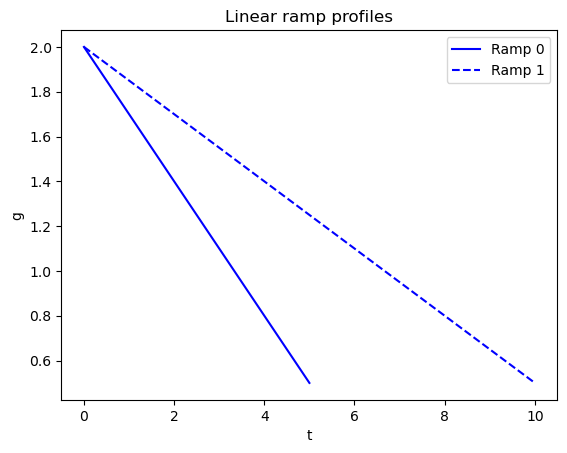

In [54]:
linestyles=['-', '--']
for ramp_idx, T in enumerate(Ts):
    ts = np.linspace(0, T, num_ts)
    plt.plot(ts, linear_ramp(ts, 0, T, g_start, g_end), c='blue', linestyle=linestyles[ramp_idx], label='Ramp ' + str(ramp_idx))

plt.ylabel('g')
plt.xlabel('t')

plt.title('Linear ramp profiles')
plt.legend()

We initialize the state $|\psi\rangle$ in the ground state at $g_{start}$, and then evolve according to the linear ramp profile.

In [60]:
# fidelities and ZZ correlations
fides = np.zeros([num_ramps, num_ts], dtype=float)
zz_corrs = np.zeros([num_ramps, num_ts, L, L], dtype=float)

for ramp_idx, T in enumerate(Ts):

    e_gs, gs = (-(ZZ + g_start*X)).eigsolve(getvecs=True)
    psi = gs[0]

    ts = np.linspace(0, T, num_ts)
    dt = ts[1] - ts[0]
    
    for t_idx, t in enumerate(ts):
        
        g_t = linear_ramp(t, 0, T, g_start, g_end)
        psi = (-(ZZ + g_t*X)).evolve(psi, dt)
               
        e_gs, gs = (-(ZZ + g_t*X)).eigsolve(getvecs=True)
        
        fides[ramp_idx, t_idx] = np.abs(psi.dot(gs[0]))

        for i in range(L):
            for j in range(L):
                zz = sigmaz(i)*sigmaz(j)
                zz.subspace = psi.subspace
                zz_corrs[ramp_idx, t_idx, i, j] = np.real(psi.dot(zz*psi))

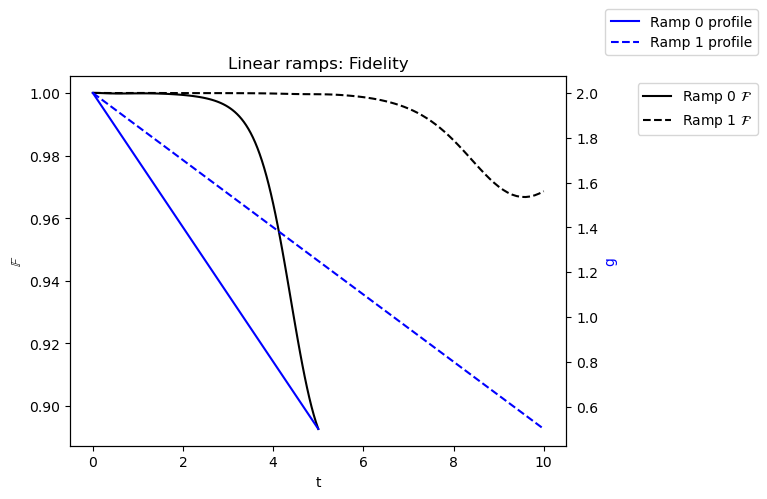

In [74]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

linestyles=['-', '--']
for ramp_idx, T in enumerate(Ts):
    ts = np.linspace(0, T, num_ts)
    ax1.plot(ts, fides[ramp_idx], 'black', linestyle=linestyles[ramp_idx], label='Ramp %d $\mathcal{F}$'%ramp_idx)
    ax2.plot(ts, linear_ramp(ts, 0, T, g_start, g_end), c='blue', linestyle=linestyles[ramp_idx], label='Ramp %d profile'%ramp_idx)

ax1.set_xlabel('t')
ax1.set_ylabel('$\mathbb{F}$')
ax2.set_ylabel('g', c='blue')

plt.title('Linear ramps: Fidelity')
ax1.legend(bbox_to_anchor=[1.4, 1.])
ax2.legend(bbox_to_anchor=[1.4, 1.2])

Doubling the ramp time can greatly increase the overlap with the instantaneous ground state! In the limit of very long times, this is known as adiabatic state preparation, where the fidelity is limited by the vanishing of the energy gap in the thermodynamic limit at $g=1$, the quantum critical point.

Similarly, we can look at the development of correlations across the system. For example, we plot the correlation function, $Z_iZ_{i+r}$, averaged over the sites $i$.

In [69]:
# average over sites i

r = 4
zz_avg = np.zeros([num_ramps, num_ts])

for i in range(L-r):
    zz_avg += zz_corrs[:, :, i, i+r]

zz_avg /= (L-r)

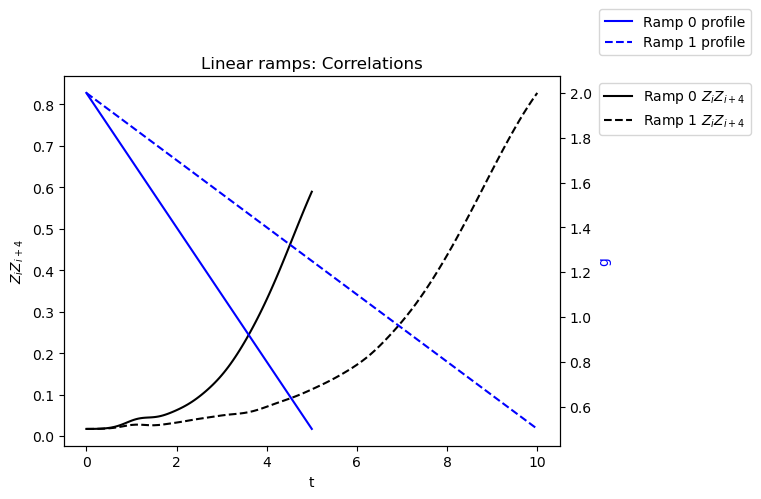

In [75]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

linestyles=['-', '--']
for ramp_idx, T in enumerate(Ts):
    ts = np.linspace(0, T, num_ts)
    ax1.plot(ts, zz_avg[ramp_idx], 'black', linestyle=linestyles[ramp_idx], label='Ramp %d $Z_i Z_{i+%d}$'%(ramp_idx, r))
    ax2.plot(ts, linear_ramp(ts, 0, T, g_start, g_end), c='blue', linestyle=linestyles[ramp_idx], label='Ramp %d profile'%ramp_idx)

ax1.set_xlabel('t')
ax1.set_ylabel('$Z_i Z_{i+%d}$'%(r))
ax2.set_ylabel('g', c='blue')

plt.title('Linear ramps: Correlations')
ax1.legend(bbox_to_anchor=[1.4, 1.])
ax2.legend(bbox_to_anchor=[1.4, 1.2])

The slower ramp allows for correlations to develop across the system, consistent with the ferromagnetic phase. In particular, for larger system sizes, there is a universal scaling prediction for the correlation length $\xi$, as a function of sweep speed. This is known as the quantum Kibble-Zurek effect (Zurek et al, Dynamics of a Quantum Phase Transition, https://doi.org/10.1103/PhysRevLett.95.105701).  